In [2]:
import sys
sys.path.insert(0, "..")
from utils.dataset_utils import OriginalDataset, plot_image_array, plot_delta

# Standard Downloads
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [3]:
original_dataset = OriginalDataset('../datasets/droid_100_sample_pictures')
len_ = (original_dataset.__len__())
print(len_)
image1 = original_dataset[0]
image1 = np.array(image1, dtype = np.int16)
image1.shape


166


(180, 320, 3)

Total number of macroblocks: 144


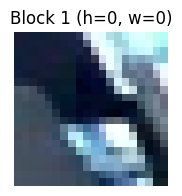

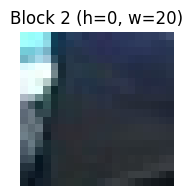

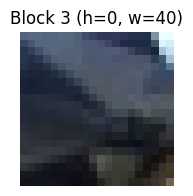

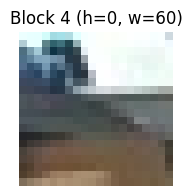

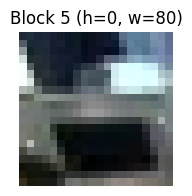

In [ ]:
# def split_and_display_macroblocks(image, block_size):
#     """
#     Splits an image into macroblocks, prints total macroblocks, and displays the first 5.
#     """
#     l, w, c = image.shape 
#     macroblocks = []  

#     # Loop through the image to extract macroblocks
#     for row in range(0, l, block_size):
#         for col in range(0, w, block_size):
#             # Extract the macroblock
#             block = image[row:row+block_size, col:col+block_size, :]
#             macroblocks.append((block, row, col))  # Store with its position

#     # Print the total number of macroblocks
#     print(f"Total number of macroblocks: {len(macroblocks)}")

#     # Display only the first 5 macroblocks
#     for i, (block, row, col) in enumerate(macroblocks[:5]):
#         plt.figure(figsize=(2, 2))  # Set a small figure size
#         plt.imshow(block.astype(np.uint8))  # Convert block to uint8 for display
#         plt.title(f"Block {i+1} (h={row}, w={col})")  # Label with position
#         plt.axis('off')  # Remove axis for cleaner display
#         plt.show()

# # Define block size
# block_size = 20

# # Split and display macroblocks
# split_and_display_macroblocks(image1, block_size)

In [14]:
def split_into_macroblocks(image, block_size):
    """
    Splits an image into macroblocks of size block_size x block_size x 3.
    """
    h, w, c = image.shape  # Get height, width, and channels
    macroblocks = []  # List to store macroblocks

    for row in range(0, h, block_size):
        for col in range(0, w, block_size):
            # Slice the image to get the macroblock
            block = image[row:row+block_size, col:col+block_size, :]
            macroblocks.append((block, row, col))  # Store with its position
    
    return macroblocks

# Correctly generate macroblocks
block_size = 20
macroblocks = split_into_macroblocks(image1, block_size)


In [15]:
import numpy as np

def predict_block(block, neighbors, mode):
    """
    Predicts a macroblock using a specific prediction mode.
    
    Parameters:
    - block: The actual macroblock (numpy array) of shape (h, w, c).
    - neighbors: A dictionary containing the neighboring pixel data:
        {
            "top": array of shape (w, c),
            "left": array of shape (h, c),
            "top_left": array of shape (c,)
        }
        If a neighbor is not available, its value should be a zero array.
    - mode: The prediction mode ("vertical", "horizontal", "dc", "planar").
    
    Returns:
    - predicted_block: The predicted macroblock of the same shape as `block`.
    """
    h, w, c = block.shape  # Height, width, and channels of the block

    if mode == "vertical":
        # Use the top row (neighbors['top']) to predict
        top_row = neighbors['top']  # Shape: (w, c)
        if top_row.shape != (w, c):
            raise ValueError(f"Expected 'top' neighbor of shape ({w}, {c}), but got {top_row.shape}")
        return np.tile(top_row[np.newaxis, :, :], (h, 1, 1))  # Expand to (h, w, c)

    elif mode == "horizontal":
        # Use the left column (neighbors['left']) to predict
        left_column = neighbors['left']  # Shape: (h, c)
        if left_column.shape != (h, c):
            raise ValueError(f"Expected 'left' neighbor of shape ({h}, {c}), but got {left_column.shape}")
        return np.tile(left_column[:, np.newaxis, :], (1, w, 1))  # Expand to (h, w, c)

    elif mode == "dc":
        # Use the average of all available neighbors
        mean_value = np.mean([
            neighbors['top'].mean(axis=0) if 'top' in neighbors and neighbors['top'].size > 0 else 0,
            neighbors['left'].mean(axis=0) if 'left' in neighbors and neighbors['left'].size > 0 else 0
        ], axis=0)  # Mean of available neighbors, shape: (c,)
        return np.full((h, w, c), mean_value)  # Fill block with mean value

    elif mode == "planar":
        # Planar prediction creates a smooth gradient based on top and left neighbors
        if 'top' in neighbors and 'left' in neighbors:
            x_gradient = np.linspace(0, 1, w).reshape(1, -1, 1)
            y_gradient = np.linspace(0, 1, h).reshape(-1, 1, 1)
            planar_prediction = (x_gradient + y_gradient) * np.mean(block, axis=(0, 1))
            return planar_prediction
        else:
            raise ValueError("Planar prediction requires both 'top' and 'left' neighbors.")

    else:
        raise ValueError(f"Unsupported prediction mode: {mode}")


### HOW TO DEFINE BEST MODE OF PREDITICTION?

H.264: Provides more granular prediction modes, especially for smaller block sizes (e.g., 4x4 and 8x8 blocks). Modes include diagonal predictions, zig-zag patterns, and other directional predictions.

In [18]:
def compare_prediction_methods_for_image(image, macroblocks, block_size):
    """
    Compare prediction methods for all macroblocks in an image using the number of zeros in the residual.
    
    Parameters:
    - image: The full image array (numpy array).
    - macroblocks: List of macroblocks [(block, row, col), ...].
    - block_size: Size of each macroblock.
    """
    modes = ["vertical", "horizontal", "dc", "planar"]
    print(f"Comparing prediction methods for all macroblocks in the image of shape {image.shape}:\n")
    
    # Loop through all macroblocks
    for idx, (block, row, col) in enumerate(macroblocks):
        print(f"Macroblock {idx+1} at position (row={row}, col={col}):")
        neighbors = {
            "top": image[row-1, col:col+block_size, :] if row > 0 else np.zeros((block_size, image.shape[2])),
            "left": image[row:row+block_size, col-1, :] if col > 0 else np.zeros((block_size, image.shape[2])),
            "top_left": image[row-1, col-1, :] if row > 0 and col > 0 else np.zeros((image.shape[2],))
        }
        
        # Compare each prediction mode
        for mode in modes:
            try:
                # Predict the block
                predicted_block = predict_block(block, neighbors, mode)
                # Compute the residual
                residual = block - predicted_block
                # Count the number of zeros in the residual
                zero_count = np.sum(residual == 0)
                # Print the result
                print(f"  Mode: {mode}")
                print(f"    Number of zeros in the residual: {zero_count}")
            except ValueError as e:
                print(f"  Mode: {mode} encountered an error: {e}")
        print("\n")  # Separate output for each macroblock

# Example Usage
# Ensure `macroblocks` is correctly generated using `split_into_macroblocks`
macroblocks = split_into_macroblocks(image1, block_size=20)

# Compare prediction methods for all macroblocks in image1
compare_prediction_methods_for_image(image1, macroblocks, block_size=20)


Comparing prediction methods for all macroblocks in the image of shape (180, 320, 3):

Macroblock 1 at position (row=0, col=0):
  Mode: vertical
    Number of zeros in the residual: 19
  Mode: horizontal
    Number of zeros in the residual: 19
  Mode: dc
    Number of zeros in the residual: 19
  Mode: planar
    Number of zeros in the residual: 0


Macroblock 2 at position (row=0, col=20):
  Mode: vertical
    Number of zeros in the residual: 0
  Mode: horizontal
    Number of zeros in the residual: 13
  Mode: dc
    Number of zeros in the residual: 0
  Mode: planar
    Number of zeros in the residual: 0


Macroblock 3 at position (row=0, col=40):
  Mode: vertical
    Number of zeros in the residual: 0
  Mode: horizontal
    Number of zeros in the residual: 23
  Mode: dc
    Number of zeros in the residual: 0
  Mode: planar
    Number of zeros in the residual: 0


Macroblock 4 at position (row=0, col=60):
  Mode: vertical
    Number of zeros in the residual: 0
  Mode: horizontal
    Nu

TBC from here. 

In [19]:
def residuals_to_binary(residuals):
    """
    Convert residuals into binary symbols for CABAC processing.
    """
    binary_symbols = []
    for coefficient in residuals.flatten():
        if coefficient != 0:
            binary_symbols.append(1)  # Non-zero coefficient flag
            binary_symbols.append(1 if coefficient > 0 else 0)  # Sign
        else:
            binary_symbols.append(0)  # Zero flag
    return binary_symbols


In [20]:
import numpy as np

def extended_predict_block(block, neighbors, mode):
    """
    Predicts a macroblock using specified prediction modes for 4x4, 8x8, and 16x16 blocks.
    
    Parameters:
    - block: The macroblock (numpy array) of shape (h, w, c).
    - neighbors: A dictionary containing neighboring pixel data:
        {
            "top": array of shape (w, c),
            "left": array of shape (h, c),
            "top_left": array of shape (c,)
        }
        If a neighbor is not available, provide a zero-filled array.
    - mode: Prediction mode (vertical, horizontal, DC, planar, diagonal, zig-zag).
    
    Returns:
    - predicted_block: The predicted block of the same shape as `block`.
    """
    h, w, c = block.shape  # Height, width, and channels of the block

    if mode == "vertical":
        # Use the top row for prediction
        top_row = neighbors["top"]  # Shape: (w, c)
        return np.tile(top_row[np.newaxis, :, :], (h, 1, 1))

    elif mode == "horizontal":
        # Use the left column for prediction
        left_column = neighbors["left"]  # Shape: (h, c)
        return np.tile(left_column[:, np.newaxis, :], (1, w, 1))

    elif mode == "dc":
        # Use the average of available neighbors
        mean_value = np.mean([
            neighbors["top"].mean(axis=0) if neighbors["top"].size > 0 else 0,
            neighbors["left"].mean(axis=0) if neighbors["left"].size > 0 else 0,
        ], axis=0)
        return np.full((h, w, c), mean_value)

    elif mode == "planar":
        # Planar prediction (smooth gradient based on top and left neighbors)
        if "top" in neighbors and "left" in neighbors:
            x_gradient = np.linspace(0, 1, w).reshape(1, -1, 1)
            y_gradient = np.linspace(0, 1, h).reshape(-1, 1, 1)
            return (x_gradient + y_gradient) * np.mean(block, axis=(0, 1))
        else:
            raise ValueError("Planar prediction requires both 'top' and 'left' neighbors.")

    elif mode == "diagonal":
        # Diagonal prediction (e.g., from top-left corner to bottom-right)
        diag_value = neighbors["top_left"] if neighbors["top_left"].size > 0 else 0
        return np.full((h, w, c), diag_value)

    elif mode == "zig-zag":
        # Zig-zag prediction (progressive diagonal filling)
        zigzag_block = np.zeros((h, w, c), dtype=block.dtype)
        idx = 0
        for diag_sum in range(h + w - 1):
            for row in range(max(0, diag_sum - w + 1), min(h, diag_sum + 1)):
                col = diag_sum - row
                zigzag_block[row, col, :] = block[idx % h, idx % w, :]
                idx += 1
        return zigzag_block

    else:
        raise ValueError(f"Unsupported prediction mode: {mode}")



In [ ]:
def process_macroblocks_h264_lossless(image, block_sizes=[4, 8, 16]):
    """
    Processes an image into macroblocks and applies H.264 lossless-like mechanisms.

    Parameters:
    - image: Input image array (H, W, C) where H = height, W = width, C = channels.
    - block_sizes: List of block sizes to use for macroblocks (default: [4, 8, 16]).

    Returns:
    - results: A list of dictionaries containing:
        {
            "block_size": (h, w),
            "position": (row, col),
            "residuals": Residual values for the block,
            "prediction_mode": Chosen prediction mode,
            "predicted_block": Predicted values for the block
        }
    """
    h, w, c = image.shape  # Height, width, channels
    results = []

    for block_size in block_sizes:
        for row in range(0, h, block_size):
            for col in range(0, w, block_size):
                # Extract the current macroblock
                block = image[row:row + block_size, col:col + block_size, :]

                # Handle boundary conditions (zero-pad if block is incomplete)
                if block.shape[0] != block_size or block.shape[1] != block_size:
                    padded_block = np.zeros((block_size, block_size, c), dtype=block.dtype)
                    padded_block[:block.shape[0], :block.shape[1], :] = block
                    block = padded_block

                # Extract neighbors
                neighbors = {
                    "top": image[row - 1, col:col + block_size, :] if row > 0 else np.zeros((block_size, c)),
                    "left": image[row:row + block_size, col - 1, :] if col > 0 else np.zeros((block_size, c)),
                    "top_left": image[row - 1, col - 1, :] if row > 0 and col > 0 else np.zeros((c,))
                }

                # Test all prediction modes
                best_mode = None
                best_residual = None
                best_predicted_block = None
                min_error = float('inf')

                for mode in ["vertical", "horizontal", "dc", "planar", "diagonal", "zig-zag"]:
                    # Predict the block
                    predicted_block = extended_predict_block(block, neighbors, mode)

                    # Compute the residual
                    residual = block - predicted_block

                    # Calculate the error (sum of absolute differences)
                    error = np.sum(np.abs(residual))

                    # Update the best mode if error is lower
                    if error < min_error:
                        min_error = error
                        best_mode = mode
                        best_residual = residual
                        best_predicted_block = predicted_block

                # Store results for this macroblock
                results.append({
                    "block_size": (block_size, block_size),
                    "position": (row, col),
                    "residuals": best_residual,
                    "prediction_mode": best_mode,
                    "predicted_block": best_predicted_block
                })

    
    return results
